# Decision Tree Analysis on ACES Dataset
This notebook explores the ACES dataset using decision trees. We perform data loading, preprocessing, model training, and evaluation, with a focus on analyzing node accuracies and generating new samples to improve the model.

In [1]:
import scipy.io
import pandas as pd
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn import tree
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

## Data Loading and Basic Exploration
We begin by loading the dataset from `.mat` files and perform initial exploration to understand the structure and content of the data.

In [2]:
def load_mat_file(file_path):
    return scipy.io.loadmat(file_path)

base_path = '/Users/asifahmed/Documents/Codes/MyRecourseProject/datasets/ACES_dataset'
expression_data = load_mat_file(f'{base_path}/ACES_RefinedCommunity_AVG.mat')
label_data = load_mat_file(f'{base_path}/ACESLabel.mat')

expression_matrix = expression_data['data']
labels = label_data['label'].flatten()  

expression_df = pd.DataFrame(expression_matrix)
labels_df = pd.Series(labels, name='label')

## Basic Data Information
Display the number of samples and features in the dataset and examine the distribution of labels to understand the class balance.

In [3]:
def basic_data_info(expression_df, labels_df):
    print(f"Number of samples (rows): {expression_df.shape[0]}")
    print(f"Number of genes (columns): {expression_df.shape[1]}")
    print("\nLabels information:")
    print(labels_df.value_counts())

basic_data_info(expression_df, labels_df)

Number of samples (rows): 1616
Number of genes (columns): 37

Labels information:
label
0    1161
1     455
Name: count, dtype: int64


## Train-Test Split
Split the dataset into training and testing sets to evaluate model performance.

In [4]:
def split_data(expression_df, labels_df, test_size=0.2, random_state=42):
    X_train, X_test, y_train, y_test = train_test_split(expression_df, labels_df, test_size=test_size, random_state=random_state)
    return X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test = split_data(expression_df, labels_df)

## Hyperparameter Tuning
We use a Decision Tree Classifier with grid search to find the best hyperparameters.

In [5]:
def perform_grid_search(X_train, y_train):
    param_grid = {
        'max_depth': [3, 5, 10, None],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4],
        'criterion': ['gini', 'entropy']
    }
    dt = DecisionTreeClassifier(random_state=42)
    grid_search = GridSearchCV(estimator=dt, param_grid=param_grid, cv=5, scoring='accuracy', verbose=0, n_jobs=-1)
    grid_search.fit(X_train, y_train)
    return grid_search

# Train the decision tree using GridSearch
grid_search = perform_grid_search(X_train, y_train)
print(f"Best Parameters: {grid_search.best_params_}")

Best Parameters: {'criterion': 'entropy', 'max_depth': 3, 'min_samples_leaf': 1, 'min_samples_split': 2}


## Initial Model Evaluation
Evaluate the performance of the decision tree model on the test set. Metrics include accuracy, classification report, and a confusion matrix.


Initial Model Evaluation:
Test Accuracy: 0.70
Classification Report:
              precision    recall  f1-score   support

           0       0.71      0.98      0.82       225
           1       0.58      0.07      0.13        99

    accuracy                           0.70       324
   macro avg       0.64      0.52      0.47       324
weighted avg       0.67      0.70      0.61       324



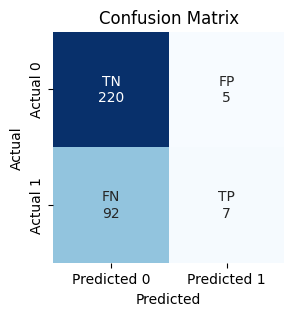

In [6]:
def train_best_model(grid_search, X_train, y_train):
    best_model = grid_search.best_estimator_
    best_model.fit(X_train, y_train)
    return best_model

best_model = train_best_model(grid_search, X_train, y_train)

def plot_confusion_matrix(y_true, y_pred, title='Confusion Matrix'):
    cm = confusion_matrix(y_true, y_pred)
    cm_df = pd.DataFrame(cm, index=["Actual 0", "Actual 1"], columns=["Predicted 0", "Predicted 1"])
    labels = np.array([["TN", "FP"], ["FN", "TP"]])
    cm_with_labels = np.array([f"{label}\n{cm_val}" for label, cm_val in zip(labels.flatten(), cm.flatten())])
    cm_with_labels = cm_with_labels.reshape(2, 2)
    
    plt.figure(figsize=(3, 3))
    sns.heatmap(cm, annot=cm_with_labels, fmt="", cmap='Blues', cbar=False, square=True, 
                xticklabels=["Predicted 0", "Predicted 1"], yticklabels=["Actual 0", "Actual 1"])
    
    plt.title(title)
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()

def evaluate_model(best_model, X_test, y_test):
    y_pred = best_model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Test Accuracy: {accuracy:.2f}")
    print("Classification Report:")
    print(classification_report(y_test, y_pred))
    plot_confusion_matrix(y_test, y_pred)

# Evaluate the initial model
print("\nInitial Model Evaluation:")
evaluate_model(best_model, X_test, y_test)

## Node Accuracy Calculation and Visualization
Calculate the accuracy of each node in the decision tree to identify how well the model performs within each node. Visualize the tree with node IDs and accuracies to better understand model decisions.


Initial Decision Tree Visualization with Node Accuracy:


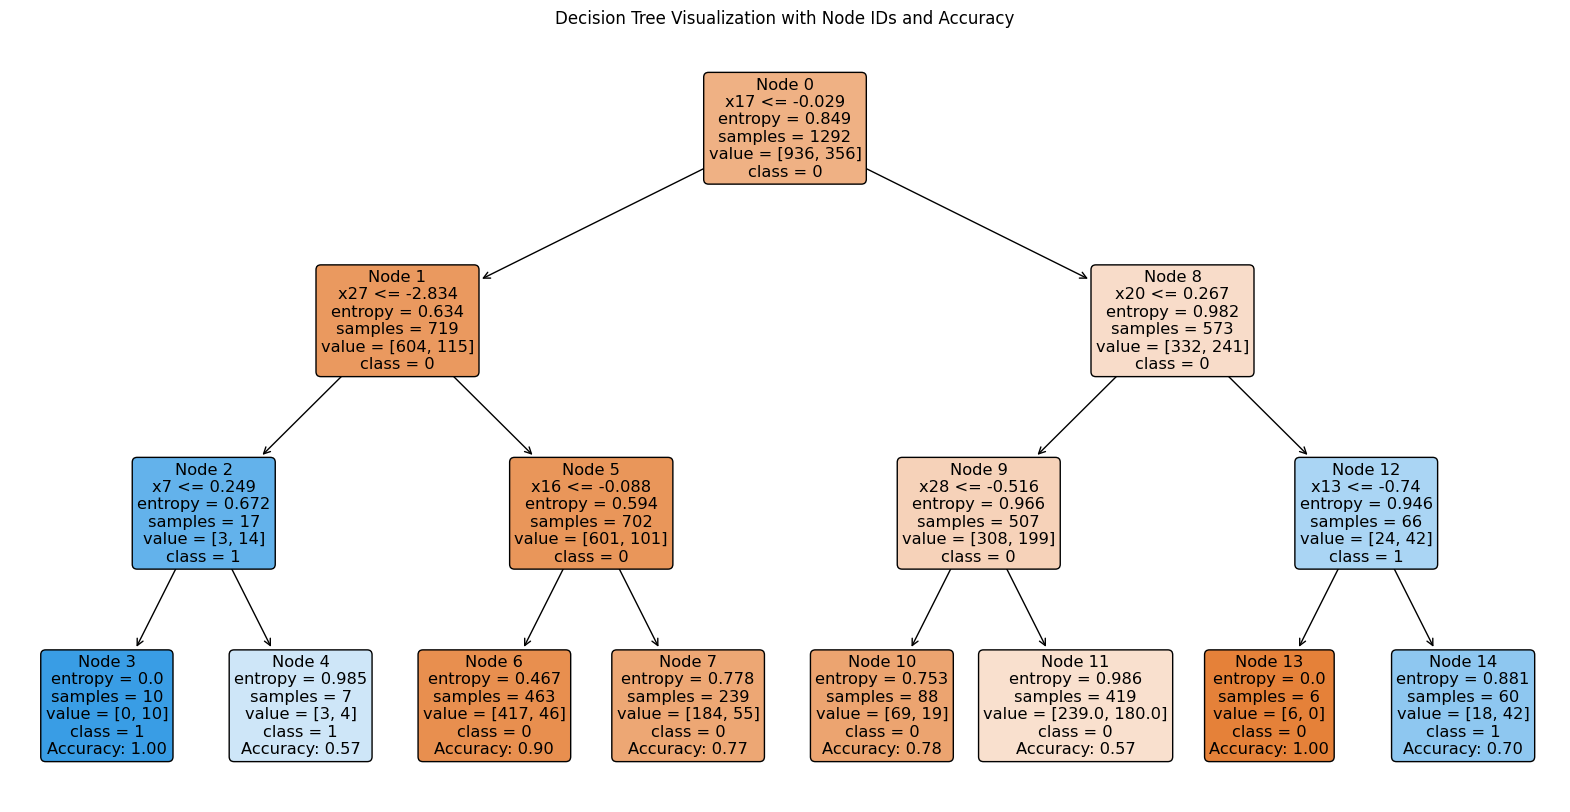

In [7]:
# Function to calculate node accuracy
def calculate_node_accuracy(tree_model, X_train, y_train):
    leaf_ids = tree_model.apply(X_train)
    node_accuracies = {}
    for node_id in np.unique(leaf_ids):
        sample_ids = np.where(leaf_ids == node_id)[0]
        y_true = y_train.iloc[sample_ids]  
        y_pred = tree_model.predict(X_train.iloc[sample_ids]) 
        correct_predictions = np.sum(y_true == y_pred)
        total_samples = len(sample_ids)
        accuracy = correct_predictions / total_samples if total_samples > 0 else 0
        node_accuracies[node_id] = accuracy
    return node_accuracies

# Calculate node accuracy
node_accuracies = calculate_node_accuracy(best_model, X_train, y_train)

def visualize_tree_with_node_accuracy(tree_model, node_accuracies, feature_names):
    plt.figure(figsize=(20, 10))
    tree_plot = tree.plot_tree(tree_model, filled=True, feature_names=feature_names, class_names=["0", "1"], rounded=True)
    ax = plt.gca()
    for idx, text in enumerate(ax.texts):
        node_id = idx
        text.set_text(f"Node {node_id}\n" + text.get_text())
        if node_id in node_accuracies:
            node_accuracy = node_accuracies[node_id]
            updated_text = text.get_text() + f"\nAccuracy: {node_accuracy:.2f}"
            text.set_text(updated_text)
    plt.title("Decision Tree Visualization with Node IDs and Accuracy")
    plt.show()

print("\nInitial Decision Tree Visualization with Node Accuracy:")
num_features = X_train.shape[1]
feature_names = [f"x{index}" for index in range(num_features)]
visualize_tree_with_node_accuracy(best_model, node_accuracies, feature_names)

## Feature Range Calculation for Nodes

To improve model's performance, we analyze the range of specific features for class 1 samples in selected nodes. This helps us understand feature distributions that could affect model performance.

Currently, we focus on node 14 and node 6. Our goal is to generate augmented data for node 14, using features that define the path to this node (x17, x20, x13). 

To make the new samples more effective, we calculate the ranges of these features and avoid overlapping with node 6’s feature ranges. Node 6’s accuracy for class 0 is nearly 90%, indicating a strong confidence in class 0 predictions. By avoiding these feature ranges, we aim to create robust samples that enhance overall model performance.

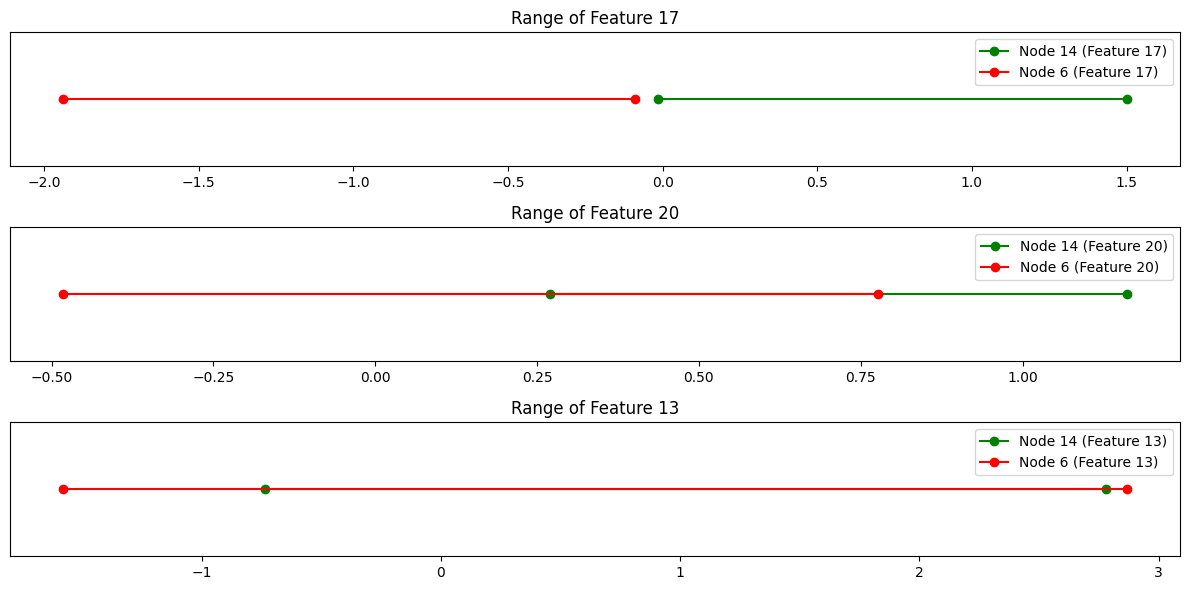

In [8]:
import matplotlib.pyplot as plt

def calculate_feature_ranges(tree_model, X_train, y_train, node_ids, features):
    ranges = {}
    for node_id in node_ids:
        leaf_ids = tree_model.apply(X_train)
        samples_in_node = X_train.iloc[leaf_ids == node_id]
        class_1_samples = samples_in_node[y_train.iloc[leaf_ids == node_id] == 1]
        ranges[node_id] = {feature: (class_1_samples.iloc[:, feature].min(), class_1_samples.iloc[:, feature].max()) for feature in features}
    return ranges

def plot_feature_ranges(ranges, features):
    colors = ["green", "red"]  
    fig, axs = plt.subplots(len(features), 1, figsize=(12, len(features) * 2))
    
    for i, feature in enumerate(features):
        for j, (node_id, node_ranges) in enumerate(ranges.items()):
            feature_range = node_ranges[feature]
            axs[i].plot(feature_range, [i]*2, marker='o', color=colors[j], label=f"Node {node_id} (Feature {feature})")
            axs[i].set_title(f"Range of Feature {feature}")
    
    for ax in axs:
        ax.legend()
        ax.set_yticks([]) 

    plt.tight_layout()
    plt.show()

features_of_interest = [17, 20, 13]
node_ids = [14, 6]
ranges = calculate_feature_ranges(best_model, X_train, y_train, node_ids, features_of_interest)

plot_feature_ranges(ranges, features_of_interest)

## Generating New Samples
Generate new samples that avoid specific feature ranges identified in a previous analysis.

We are generating same amount of class 1 samples in node 14.

In [9]:
def can_avoid_range(valid_range, avoid_range):
    return not (valid_range[0] >= avoid_range[0] and valid_range[1] <= avoid_range[1])

def sample_avoiding_range(valid_range, avoid_range):
    if not can_avoid_range(valid_range, avoid_range):
        return np.random.uniform(valid_range[0], valid_range[1])
    while True:
        value = np.random.uniform(valid_range[0], valid_range[1])
        if not (avoid_range[0] <= value <= avoid_range[1]):
            return value

def generate_avoiding_samples(node_14_data, node_14_ranges, node_6_ranges, num_samples):
    np.random.seed(42)
    generated_samples = []
    for _ in range(num_samples):
        sample = {}
        for feature in [13, 17, 20]:
            valid_range = node_14_ranges[feature]
            avoid_range = node_6_ranges[feature]
            sample[feature] = sample_avoiding_range(valid_range, avoid_range)
        other_features = node_14_data.drop(columns=[13, 17, 20]).sample(n=1, replace=True).iloc[0].to_dict()
        sample.update(other_features)
        generated_samples.append(sample)
    
    generated_samples_df = pd.DataFrame(generated_samples)
    
    desired_order = node_14_data.columns.tolist()
    generated_samples_df = generated_samples_df[desired_order]
    generated_samples_df['label'] = 1  # Assign label 1 for class 1 samples

    return generated_samples_df

features_of_interest = [13, 17, 20]  # Features defining the path to node 14
node_ids = [14, 6]  # Node 14 for class 1 and node 6 for class 0
ranges = calculate_feature_ranges(best_model, X_train, y_train, node_ids, features_of_interest)

node_14_data = X_train[(best_model.apply(X_train) == 14) & (y_train == 1)]  # Class 1 samples from node 14
node_14_ranges = ranges[14]
node_6_ranges = ranges[6]

# Generate samples avoiding the ranges of node 6
num_class_1_samples_node_14 = len(node_14_data)
generated_samples = generate_avoiding_samples(node_14_data, node_14_ranges, node_6_ranges, num_samples=num_class_1_samples_node_14)

print(f"Number of generated samples: {len(generated_samples)}")

Number of generated samples: 42


## Decision Tree Visualization and Retraining with Augmented Data
In this section, we start by visualizing the initial decision tree with node accuracy annotations. We then augment the training data with newly generated samples and retrain the decision tree using the best hyperparameters obtained from grid search. 

Finally, we visualize the retrained tree and evaluate its performance on the test set to observe any improvements.


Initial Decision Tree Visualization with Node Accuracy:


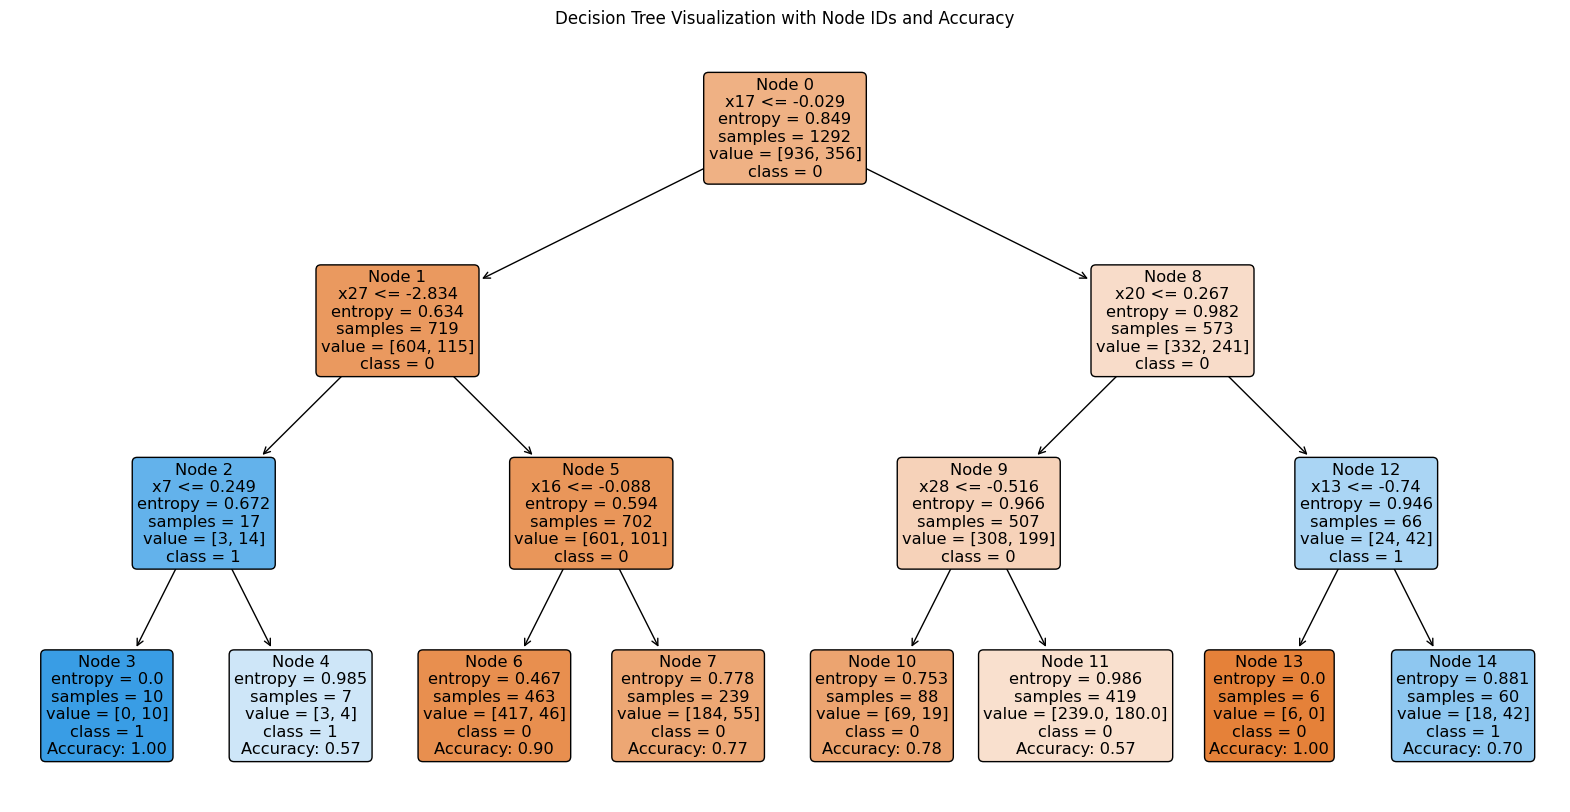

Best Parameters for Retrained Model: {'criterion': 'entropy', 'max_depth': 3, 'min_samples_leaf': 4, 'min_samples_split': 2}

Visualization of Retrained Decision Tree with Node Accuracy:


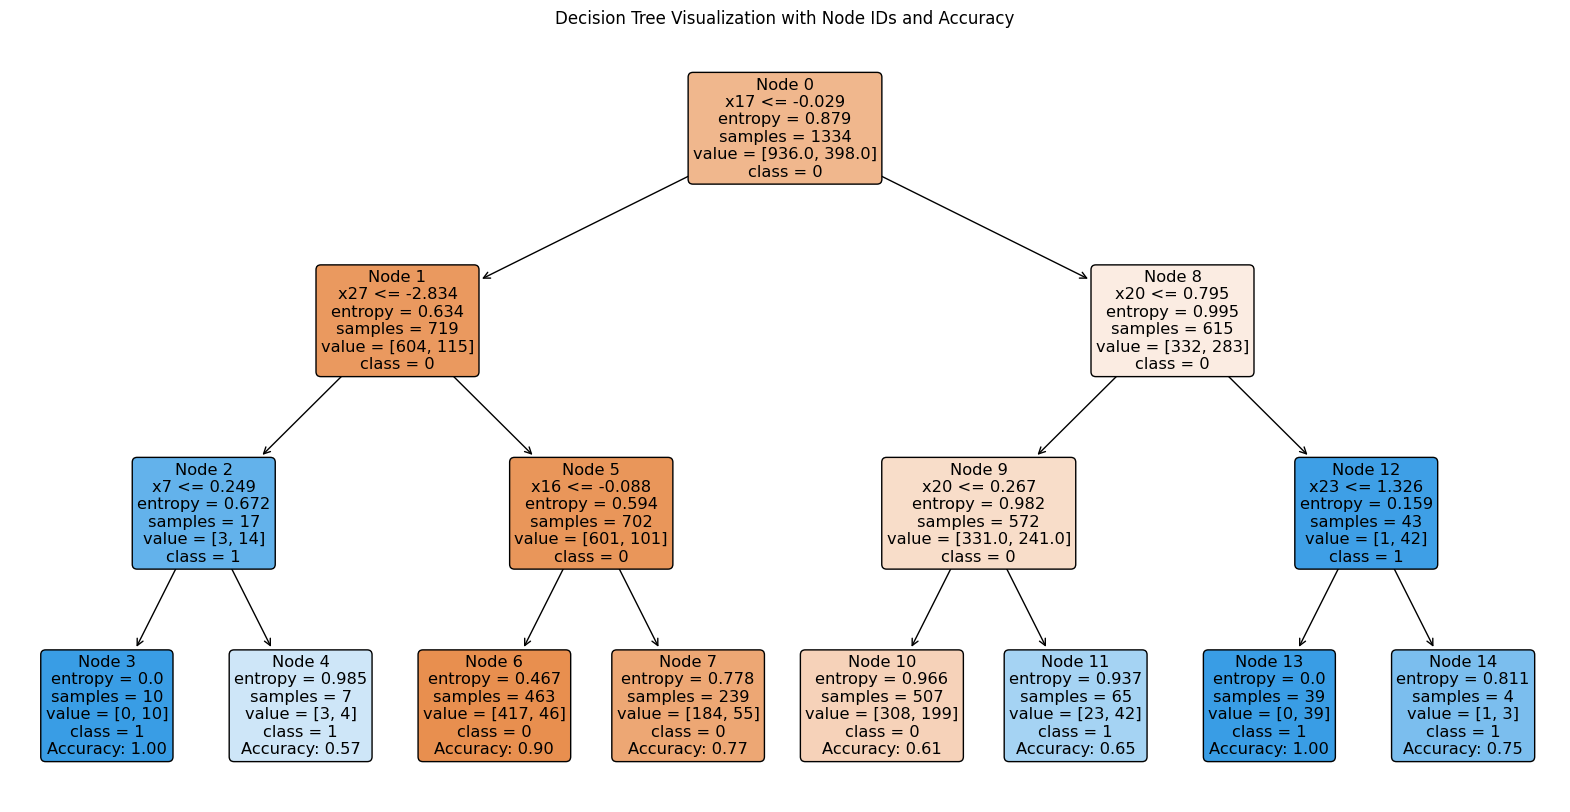


Evaluation of the Retrained Model:
Test Accuracy: 0.70
Classification Report:
              precision    recall  f1-score   support

           0       0.71      0.98      0.82       225
           1       0.62      0.08      0.14        99

    accuracy                           0.70       324
   macro avg       0.66      0.53      0.48       324
weighted avg       0.68      0.70      0.61       324



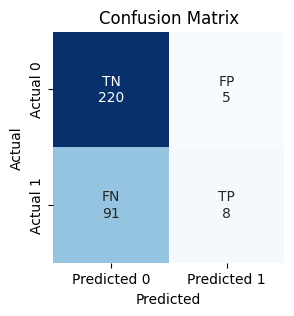

In [10]:
# Plot the initial decision tree with node accuracy
print("\nInitial Decision Tree Visualization with Node Accuracy:")
num_features = X_train.shape[1]
feature_names = [f"x{index}" for index in range(num_features)]
visualize_tree_with_node_accuracy(best_model, node_accuracies, feature_names)

# Combine the generated samples with the original training data
X_train_augmented = pd.concat([X_train, generated_samples.drop(columns=['label'])], ignore_index=True)
y_train_augmented = pd.concat([y_train, generated_samples['label']], ignore_index=True)

# Perform grid search on the augmented data
grid_search_augmented = perform_grid_search(X_train_augmented, y_train_augmented)
print(f"Best Parameters for Retrained Model: {grid_search_augmented.best_params_}")

# Retrain the model with the best parameters from grid search
best_retrained_model = train_best_model(grid_search_augmented, X_train_augmented, y_train_augmented)

# Calculate node accuracy for the retrained model
node_accuracies_retrained = calculate_node_accuracy(best_retrained_model, X_train_augmented, y_train_augmented)

# Plot the retrained decision tree with node accuracy
print("\nVisualization of Retrained Decision Tree with Node Accuracy:")
visualize_tree_with_node_accuracy(best_retrained_model, node_accuracies_retrained, feature_names)

# Evaluate the retrained model on the test set
print("\nEvaluation of the Retrained Model:")
evaluate_model(best_retrained_model, X_test, y_test)